In [15]:
#IMPORT MODULES
from Bio import SeqIO
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gzip
import sys
import os
from collections import defaultdict
from Bio.Blast import NCBIXML
from Bio.SeqFeature import SeqFeature
import subprocess
import gzip
import pypangraph as pp
from collections import Counter
import csv
import re
import seaborn as sns
from geopy.geocoders import Nominatim
from scipy.cluster.hierarchy import linkage, leaves_list

#IMPORT FILES
meta_data='/Users/jferrare/Documents/Good Lab Work/Gut Phage/uhgv_metadata.tsv.gz' #874051 rows
genomes='/Users/jferrare/Documents/Good Lab Work/Gut Phage/uhgv_mgv.fna.gz'
ani_results='/Users/jferrare/Documents/Good Lab Work/Gut Phage/combined_uhgv_mgv_ani.txt' #30700847 rows
blast_results='/Users/jferrare/Documents/Good Lab Work/Gut Phage/combined_uhgv_mgv_blast_results.txt' #165831139 rows
sequence_counts_file='/Users/jferrare/Documents/Good Lab Work/Gut Phage/February_2025/votu_sequence_counts.txt'
ani_columns=['query_id', 'subject_id', 'num_alns', 'percent_identity', 'query_coverage', 'target_coverage']
blast_columns=['query_id','subject_id','percent_identity','length','mismatch','gapopen','qstart','qend','sstart','send','evalue','bitscore'] 
meta_columns=['uhgv_genome','uhgv_votu','votu_representative','original_study_alias','original_id','genome_length','is_jumbo_phage','gc_percent','checkv_quality','checkv_completeness','checkv_completeness_method','checkv_trimmed','viral_confidence','genomad_virus_score','genomad_virus_hallmarks','genomad_plasmid_hallmarks','viralverify_prediction','viralverify_score','checkv_viral_markers','checkv_host_markers','cds_count','cds_density','avg_cds_length','genetic_code',	'is_recoded','trna_count_total','trna_count_suppressor','sra_run','sra_sample','biosample','country','latitude','longitude']


In [16]:
# Load sequence-to-vOTU mapping
sequence_to_votu = {}
with gzip.open(meta_data, 'rt') as f:
    for line in f:
        if line.startswith('uhgv_genome'):
            continue
        parts = line.strip().split('\t')
        sequence_to_votu[parts[0]] = parts[1]

#define function to get continent from latitude and longitude
def get_continent(country,latitude, longitude):
    # List of European countries
    European_countries=['Netherlands','Russian Federation','Albania', 'Andorra', 'Armenia', 'Austria', 'Azerbaijan', 'Belarus', 'Belgium', 'Bosnia and Herzegovina', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Georgia', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy', 'Kosovo', 'Latvia', 'Liechtenstein', 'Lithuania', 'Luxembourg', 'Malta', 'Moldova', 'Monaco', 'Montenegro', 'Netherlands', 'North Macedonia', 'Norway', 'Poland', 'Portugal', 'Romania', 'Russia', 'San Marino', 'Serbia', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Turkey', 'Ukraine', 'United Kingdom', 'Vatican City']
    North_american_countries=['Canada','United States','Mexico','Greenland','Belize','Guatemala','Honduras','El Salvador','Nicaragua','Costa Rica','Panama','Jamaica','Haiti','Dominican Republic','Cuba','Bahamas','Barbados','Saint Lucia','Saint Vincent and the Grenadines','Grenada','Trinidad and Tobago','Saint Kitts and Nevis','Antigua and Barbuda','Dominica','Saint Martin','Sint Maarten','Saint Barthelemy','Anguilla','Montserrat','Guadeloupe','Martinique','Saint Pierre and Miquelon','Bermuda','Turks and Caicos Islands','Cayman Islands','British Virgin Islands','United States Virgin Islands','Puerto Rico','Dominican Republic','Haiti','Cuba','Jamaica','Bahamas','Turks and Caicos Islands','Honduras','Nicaragua','Costa Rica','Panama','Belize','Guatemala','El Salvador','Mexico','Canada','United States']
    South_american_countries=['Argentina','Bolivia','Brazil','Chile','Colombia','Ecuador','Guyana','Paraguay','Peru','Suriname','Uruguay','Venezuela']
    
    if country in European_countries:
        return 'Europe'

    elif country in North_american_countries:
        return 'North America'

    elif country in South_american_countries:
        return 'South America'
    
    # North America
    elif 23.0 < latitude <= 60.0 and -135.0 <= longitude <= -60.0:
        return "North America"
    
    # South America
    elif -56.0 <= latitude <= 15.0 and -90.0 <= longitude <= -30.0:
        return "South America"
    
    # Europe
    elif 30.0 <= latitude <= 85.0 and -15.0 < longitude < 45.0:
        return "Europe"
    
    # Asia
    elif 0.0 <= latitude <= 77.0 and 45.0 <= longitude <= 165.0:
        return "Asia"
    
    # Africa
    elif -30.0 <= latitude < 60.0 and 15.0 <= longitude < 45.0:
        return "Africa"
    
    # If not within any of the above bounds
    else:
        return "Continent not recognized"
    
# Function to extract vOTUs from filenames in a given folder
def extract_votus(folder_path):
    votus = []
    ns = []
    
    # Iterate over files in the specified folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".fna"):
            # Extract vOTU part from the filename (before the first underscore)
            votu = filename.split('_')[0]
            n = filename.split('_')[1].split('.')[0][1::]
            votus.append(votu)
            ns.append(int(n))
    
    return votus, ns


In [21]:
# extract votu, continent, latitude, and longitude for each sequence
sequences_ids = set()
sequences=[]
votus=[]

# Read genomes file and store sequence IDs in the set
with gzip.open(genomes, 'rt') as f:
    sequences_ids = {record.id for record in SeqIO.parse(f, 'fasta')}

# Initialize lists for latitudes and longitudes
lats, longs, votus, continents, countries = [], [], [] , [], []

# Read the metadata file and process only the relevant rows
with gzip.open(meta_data, 'rt') as f:
    for line in f:
        line = line.strip().split('\t')
        if line[0] in sequences_ids:  # Faster set lookup
            try:
                country=line[-3]
                try:
                    lat=float(line[-2])
                    long=float(line[-1])
                except:
                    lat=10000
                    long=10000
                continent=get_continent(country,lat,long)
                votu=sequence_to_votu[line[0]]

                #append data
                sequences.append(line[0])
                continents.append(continent)
                lats.append(lat)  # Assuming latitudes are numeric
                longs.append(long)  # Assuming longitudes are numeric
                votus.append(votu)
                countries.append(country)
            except:
                print(line)
                sequences.append(line[0])
                continents.append(0)
                votus.append(0)
                lats.append(0)  # Assuming latitudes are numeric
                longs.append(0)  # Assuming longitudes are numeric



In [12]:
#identify votu counts by continent
import pandas as pd
from collections import defaultdict

# Create a DataFrame from the collected data
data = pd.DataFrame({
    'sequence': sequences,
    'votu': votus,
    'continent': continents
})

# Count sequences per vOTU and continent
count_table = data.groupby(['votu', 'continent']).size().unstack(fill_value=0)

# Save to a file or display
count_table.to_csv('/Users/jferrare/Documents/Good Lab Work/Gut Phage/votu_continent_counts.csv')
#normalize counts by column
count_table_norm = count_table.div(count_table.sum(axis=0), axis=1)
#subset count_table_norm to rows that have at least one value>0.01
count_table_norm_subset=count_table_norm[(count_table_norm>0.002).any(axis=1)]
#subset to rows that are nonzero in all columns: 'Africa', 'Asia', 'Europe', 'North America', 'South America'
count_table_norm_subset2=count_table[(count_table['Africa']>0)&(count_table['Asia']>0)&(count_table['Europe']>0)&(count_table['North America']>0)&(count_table['South America']>0)]
#save to file
count_table_norm_subset2.to_csv('/Users/jferrare/Documents/Good Lab Work/Gut Phage/votus_inallcontinent_counts.csv')








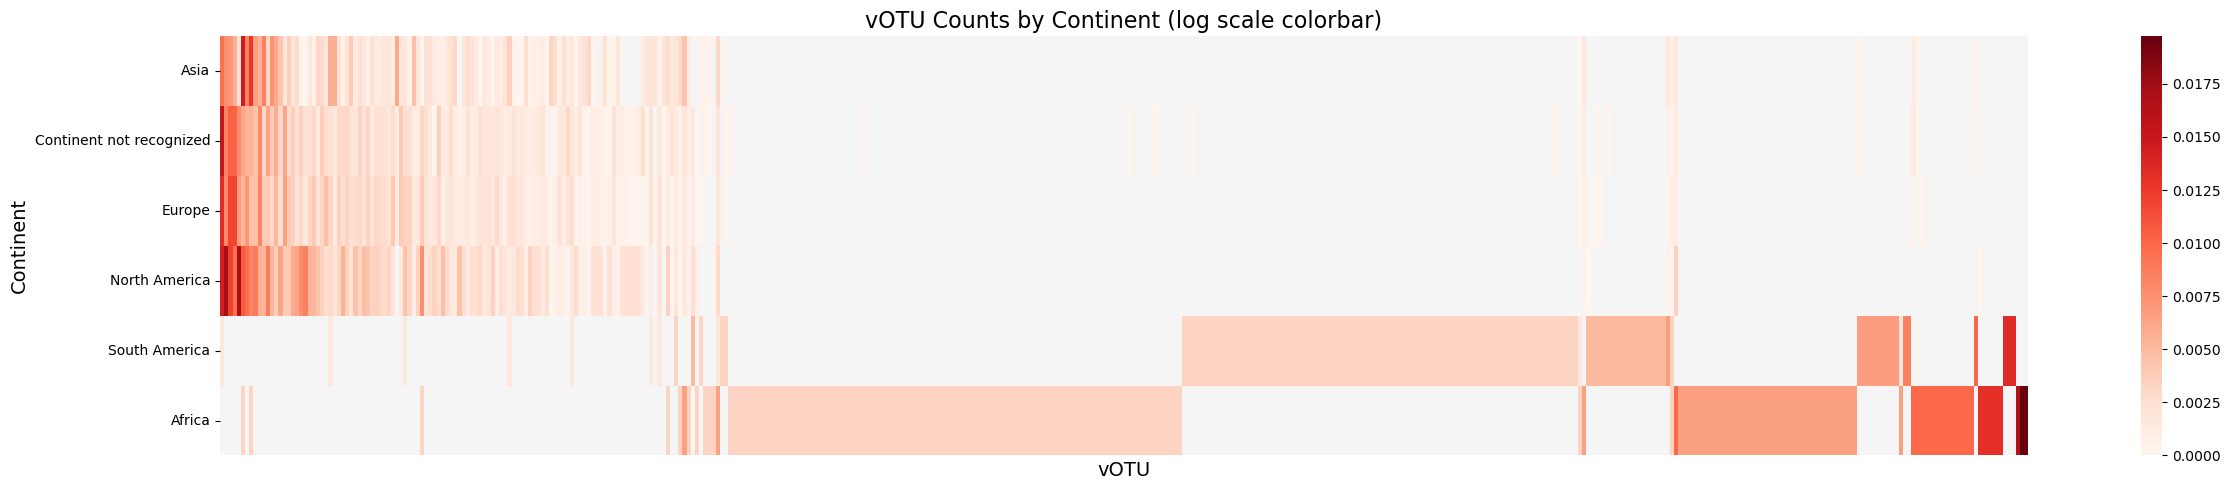

In [208]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import LogNorm
from matplotlib.colors import LinearSegmentedColormap
cmap1 = LinearSegmentedColormap.from_list("grey_reds", [(0, 'white'), (0.001, 'white')] + [(x, plt.cm.Reds(x)) for x in np.linspace(0.001, 1, 256)])

filtered_table = count_table_norm_subset
# Move Africa to the bottom
africa_data = filtered_table['Africa']
filtered_table = filtered_table.drop('Africa', axis=1)
filtered_table['Africa'] = africa_data

#sort by average value in 'Europe','North America' and 'Asia' - average value in 'Africa' and 'South America'
# Calculate average values for 'Europe', 'North America', and 'Asia'
continent_avg = filtered_table[['Europe', 'North America', 'Asia']].mean(axis=1)

# Calculate average values for 'Africa' and 'South America' (to use for sorting)
other_continent_avg = filtered_table[['Africa', 'South America']].mean(axis=1)

#subtract other_continent_avg from continent_avg
continent_avg=continent_avg-other_continent_avg
#sort votus in filtered table by continent_avg
filtered_table = filtered_table.loc[continent_avg.sort_values(ascending=False).index]

# Create a heatmap with log color scale
plt.figure(figsize=(25, 5))
sns.heatmap(
    filtered_table.transpose(), 
    cmap=cmap1
)

# Add labels and title
plt.title('vOTU Counts by Continent (log scale colorbar)', fontsize=16)
plt.xlabel('vOTU', fontsize=14)
plt.ylabel('Continent', fontsize=14)

#no xticks
plt.xticks([])

# Show the plot
plt.tight_layout()
plt.show()



441


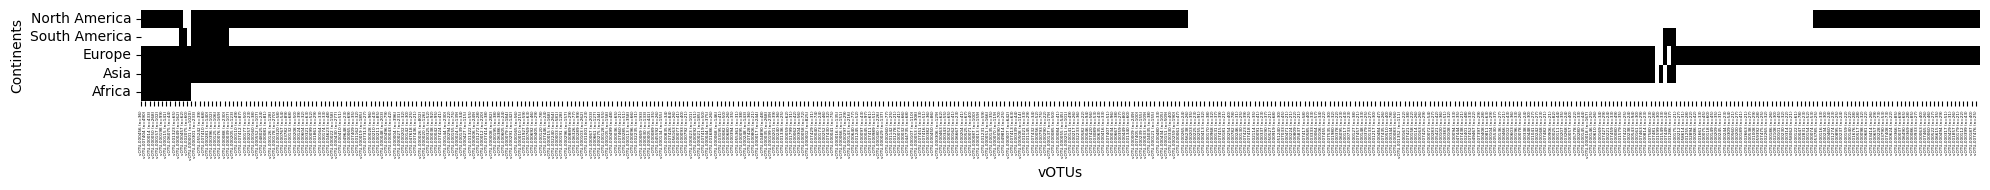

In [25]:
#plot vOTU absence/presence heatmap across continents

# Function to extract vOTUs from filenames in a given folder
def extract_votus(folder_path):
    votus = []
    ns = []
    
    # Iterate over files in the specified folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".fna"):
            # Extract vOTU part from the filename (before the first underscore)
            votu = filename.split('_')[0]
            n = filename.split('_')[1].split('.')[0][1::]
            votus.append(votu)
            ns.append(int(n))
    
    return votus, ns

# Example usage: path to the folder containing the vOTUs
folder_path = "/Users/jferrare/Documents/Good Lab Work/Gut Phage/January_2025/large_vOTUs"
votu_list, ns_list = extract_votus(folder_path)



# Initialize binary columns for each continent
votu_continents = {votu: {'North America': 0, 'South America': 0, 'Europe': 0, 'Asia': 0} for votu in votu_list}

# Iterate over sequences and assign continent columns based on coordinates
for seq, lat, lon in zip(sequences, lats, longs):
    votu = sequence_to_votu[seq]
    continent = get_continent_2(lat, lon)
    if continent in ['North America', 'South America', 'Europe', 'Asia', 'Africa'] and votu in votu_list:
        votu_continents[votu][continent] = 1

# Create a DataFrame for the heatmap
heatmap_data = []

# Fill the heatmap_data list with 1 or 0 for each vOTU and continent
for continent in ['North America', 'South America', 'Europe', 'Asia', 'Africa']:
    continent_data = []
    for votu in votu_list:
        continent_data.append(votu_continents.get(votu, {}).get(continent, 0))
    heatmap_data.append(continent_data)

# Convert the list into a DataFrame for easier visualization
heatmap_df = pd.DataFrame(heatmap_data, columns=votu_list, index=['North America', 'South America', 'Europe', 'Asia', 'Africa'])

# Perform hierarchical clustering on vOTUs based on their continent presence
votu_similarity = linkage(heatmap_df.T, method='ward', metric='euclidean')  # Perform hierarchical clustering
ordered_votus = heatmap_df.columns[leaves_list(votu_similarity)].to_list()  # Get ordered vOTUs

# Reorder the DataFrame columns based on clustering results
heatmap_df = heatmap_df[ordered_votus]

# Modify the x-axis labels to include n values
ordered_ns = [ns_list[votu_list.index(votu)] for votu in ordered_votus]
ordered_votu_labels = [f"{votu} (n={n})" for votu, n in zip(ordered_votus, ordered_ns)]
print(len(ordered_votu_labels))
# Create the heatmap
plt.figure(figsize=(20, 2))
sns.heatmap(heatmap_df, cmap='binary', cbar=False, linecolor='red', annot=False)

# Set labels and title
#make xtickslabel fontsize smaller
plt.subplots_adjust(bottom=.5)
plt.xticks(fontsize=3)
plt.xlabel("vOTUs")
plt.ylabel("Continents")

# Update x-axis with labels that include 'n'
plt.xticks(ticks=np.arange(len(ordered_votu_labels)), labels=ordered_votu_labels, rotation=90)

# Show the heatmap
plt.tight_layout()
plt.show()


In [165]:
#create a html proportional map of vOTU presence across the globe
import folium
import pandas as pd
from collections import Counter

z = list(zip(lats, longs,votus))
#remove 0,0 coordinates
z=[(lat,long,votu) for lat,long,votu in z if lat!=0 and long!=0]

#focus on specific votu
#focal_votu='vOTU-007429'

#subset z to only include the focal votu
#z=[(lat,long,votu) for lat,long,votu in z if votu==focal_votu]

# Find unique combinations of latitudes and longitudes and count instances
counts = Counter(z)

# Initialize an empty list to store the results
lat_long = []

# Iterate through counts and append to the list
for key, value in counts.items():
    lat_long.append([key[0], key[1], value])

# Convert the list into a DataFrame
df = pd.DataFrame(lat_long, columns=['Latitude', 'Longitude', 'Count'])
df = df[(df['Latitude'] != 0) | (df['Longitude'] != 0)]

# Create a base map centered globally (around [0, 0]) and no zoom to show the whole globe
m = folium.Map(location=[0, 0], zoom_start=1)

# Define a size scale based on the counts (you can adjust this factor to control the scaling)
size_factor = .1  # Adjust this to make the circles larger or smaller

# Add circle markers to the map
for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=row['Count'] * size_factor,  # Size proportional to count
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6,
        popup=f"Count: {row['Count']}"
        
    ).add_to(m)


# Save the map to an HTML file
#m.save(f"/Users/jferrare/Downloads/{focal_votu}_proportional_map.html")
m.save("/Users/jferrare/Downloads/new_proportional_map.html")


